# Lightgbm Implementation

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from joblib import dump

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [16]:
# Leer el archivo CSV
pumps_df = pd.read_csv("/content/pumps_cleaned.csv")
pumps_df.shape

(57587, 18)

## 1. Validacion inicial de datos

In [17]:
pumps_df.head()

,id,longitude,latitude,region,extraction_type,management,payment_type,quality_group,quantity_group,source,waterpoint_type,status_group,population_imputed,altitud,construction_year_imputed,scheme_management_imputed,permit_imputed,gdp_per_capita
0,69572,34.938093,-9.856322,Iringa,gravity,vwc,annually,good,enough,spring,communal standpipe,functional,109.000000,1367.0,1999.0,VWC,False,4028.5
1,8776,34.698766,-2.147466,Mara,gravity,wug,never pay,good,insufficient,rainwater harvesting,communal standpipe,functional,280.000000,1440.0,2010.0,Other,True,2258.3
2,34310,37.460664,-3.821329,Manyara,gravity,vwc,per bucket,good,enough,dam,communal standpipe multiple,functional,250.000000,699.0,2009.0,VWC,True,2654.6
3,67743,38.486161,-11.155298,Mtwara,submersible,vwc,never pay,good,dry,machine dbh,communal standpipe multiple,non functional,58.000000,254.0,1986.0,VWC,True,2725.2
4,19728,31.130847,-1.825359,Kagera,gravity,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,functional,500.316472,1675.0,1996.0,Other,True,1168.7


In [18]:
pumps_df['status_group'].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

In [19]:
# Ver información básica
print(pumps_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57587 entries, 0 to 57586
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         57587 non-null  int64  
 1   longitude                  57587 non-null  float64
 2   latitude                   57587 non-null  float64
 3   region                     57587 non-null  object 
 4   extraction_type            57587 non-null  object 
 5   management                 57587 non-null  object 
 6   payment_type               57587 non-null  object 
 7   quality_group              57587 non-null  object 
 8   quantity_group             57587 non-null  object 
 9   source                     57587 non-null  object 
 10  waterpoint_type            57587 non-null  object 
 11  status_group               57587 non-null  object 
 12  population_imputed         57587 non-null  float64
 13  altitud                    57587 non-null  flo

In [20]:
print(pumps_df.describe())

                 id     longitude      latitude  population_imputed  \
count  57587.000000  57587.000000  57587.000000        57587.000000   
mean   37106.845017     35.149709     -5.885629          529.789624   
std    21454.529492      2.607433      2.809868          619.190970   
min        0.000000     29.607122    -11.649440            4.000000   
25%    18523.500000     33.285198     -8.643850          150.000000   
50%    37055.000000     35.005964     -5.172737          350.000000   
75%    55667.500000     37.233727     -3.372874          700.000000   
max    74247.000000     40.345193     -0.998464        30500.000000   

            altitud  construction_year_imputed  gdp_per_capita  
count  57587.000000               57587.000000    57587.000000  
mean    1083.695713                1996.848091     2709.263643  
std      530.474217                  10.348323      877.500680  
min        0.000000                1960.000000     1168.700000  
25%      743.000000                

In [21]:
# Comprobar valores únicos en la variable objetivo
print(pumps_df['status_group'].value_counts())

status_group
functional                 31389
non functional             22267
functional needs repair     3931
Name: count, dtype: int64


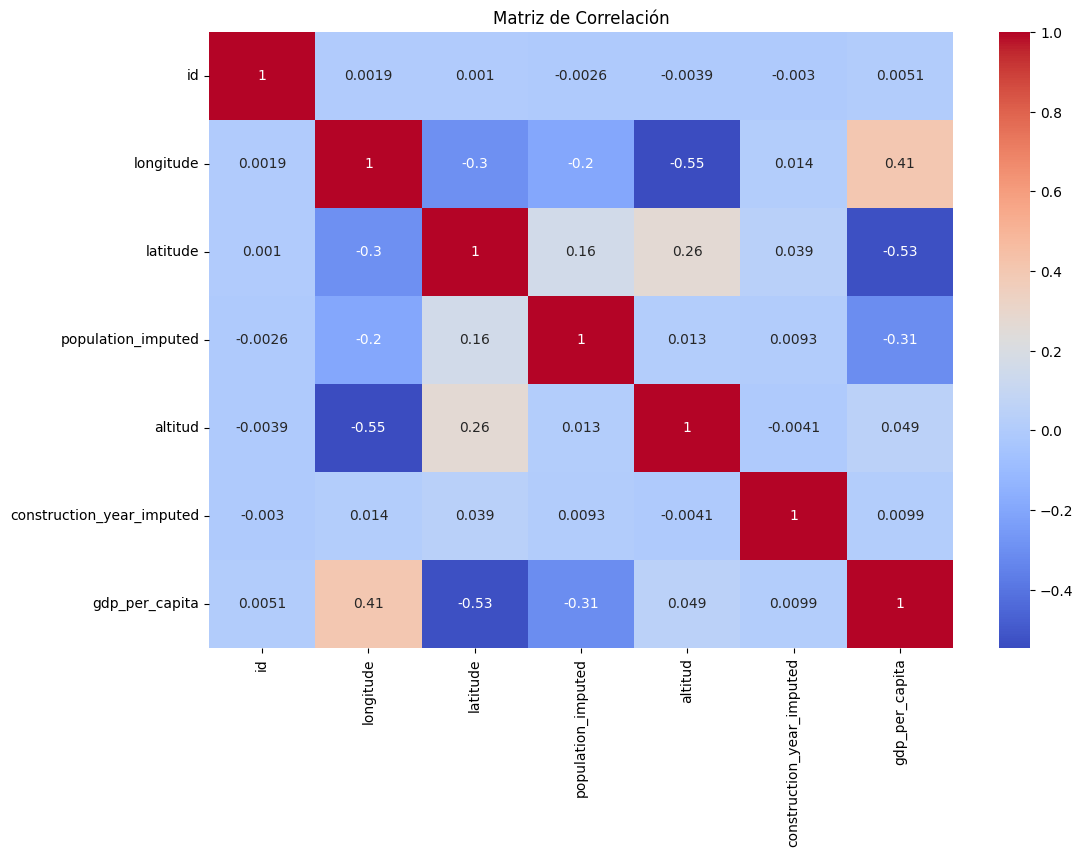

In [22]:
# Matriz de correlación
numerical_features = pumps_df.select_dtypes(include=[np.number])
correlation_matrix = numerical_features.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()

## 2. Preparacion de los datos

In [23]:
# Codificar la variable objetivo
le = LabelEncoder()
pumps_df['status_group'] = le.fit_transform(pumps_df['status_group'])

In [24]:
# Imprimir las clases y sus respectivas codificaciones
print(le.classes_)

['functional' 'functional needs repair' 'non functional']


Entonces:

- 0 corresponde a 'functional'
- 1 corresponde a 'non functional'
- 2 corresponde a 'functional needs repair'

In [25]:
# Dividir características y la variable objetivo
X = pumps_df.drop(columns=['status_group','id'])
y = pumps_df['status_group']

In [26]:
# Codificar variables categóricas
X = pd.get_dummies(X, drop_first=True)

In [27]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}")

Conjunto de entrenamiento: (40310, 92)
Conjunto de prueba: (17277, 92)


## 3. Entrenamiento del modelo LightGBM

In [29]:
import lightgbm
print(lightgbm.__version__)

4.5.0


In [30]:
# Crear los datos LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [31]:
# Crear y entrenar el modelo con validación
model = LGBMClassifier(
    objective='multiclass',
    num_class=len(le.classes_),
    learning_rate=0.1,
    num_leaves=31,
    max_depth=-1,
    metric='multi_logloss',
    verbosity=-1,
    n_estimators=100
)

In [32]:
# Entrenamiento con validación y early stopping
model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='multi_logloss',
    callbacks=[early_stopping(stopping_rounds=10), log_evaluation(period=10)]
)

Training until validation scores don't improve for 10 rounds
[10]	valid_0's multi_logloss: 0.663277
[20]	valid_0's multi_logloss: 0.607488
[30]	valid_0's multi_logloss: 0.580843
[40]	valid_0's multi_logloss: 0.565894
[50]	valid_0's multi_logloss: 0.55596
[60]	valid_0's multi_logloss: 0.548836
[70]	valid_0's multi_logloss: 0.543704
[80]	valid_0's multi_logloss: 0.538718
[90]	valid_0's multi_logloss: 0.535265
[100]	valid_0's multi_logloss: 0.531502
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.531502


LGBMClassifier(metric='multi_logloss', num_class=3, objective='multiclass',
               verbosity=-1)

In [33]:
# Predicción
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7834693523181108


In [34]:
print(y_pred[:10])

[0 0 0 2 0 2 1 0 0 0]


In [35]:
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83      9390
           1       0.65      0.17      0.27      1190
           2       0.84      0.70      0.77      6697

    accuracy                           0.78     17277
   macro avg       0.75      0.60      0.62     17277
weighted avg       0.78      0.78      0.77     17277

Accuracy: 0.7834693523181108


## 4. Análisis de caracteristicas importantes

In [36]:
# Importancia de características
importance = model.feature_importances_
feature_names = X_train.columns

In [37]:
# Crear un DataFrame para visualizar la importancia
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

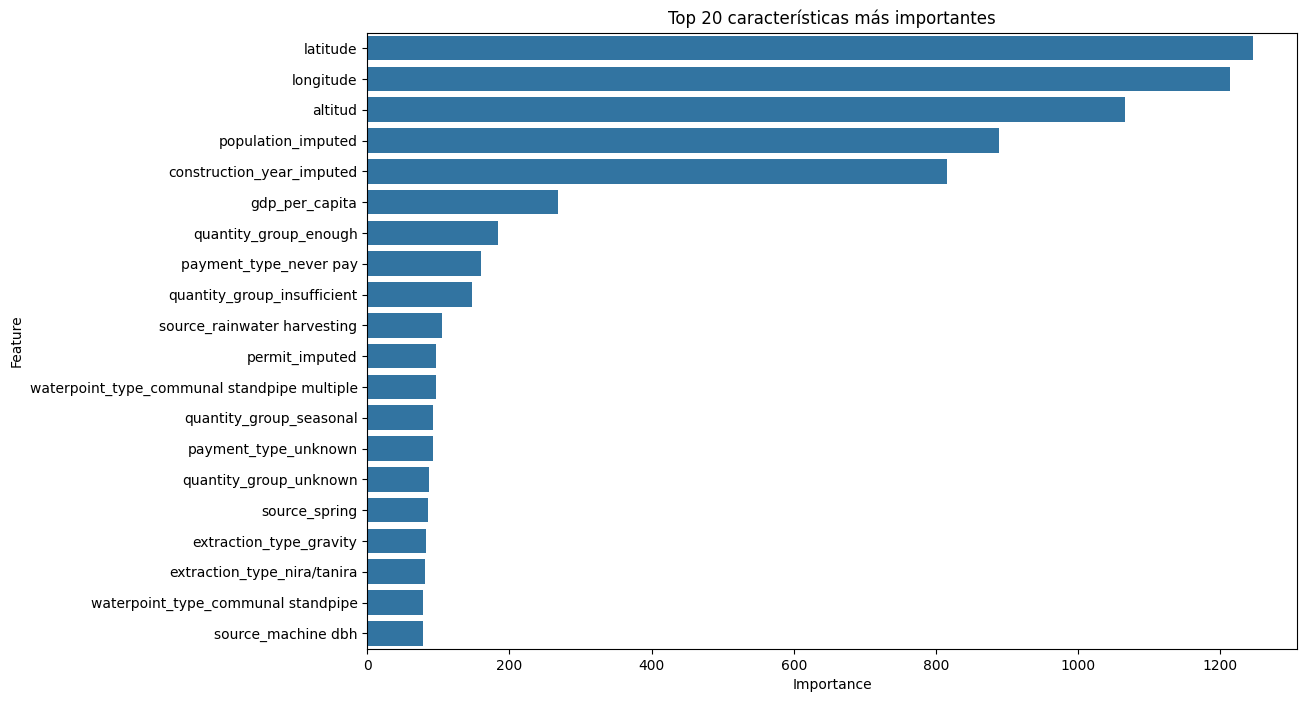

In [38]:
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_df.head(20), x='Importance', y='Feature')
plt.title("Top 20 características más importantes")
plt.show()

## 5. Busqueda de hiperparametros

In [39]:
from sklearn.model_selection import GridSearchCV

In [40]:
# Parámetros para buscar
param_grid = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

In [41]:
# Modelo base
lgb_estimator = lgb.LGBMClassifier(objective='multiclass', num_class=len(le.classes_))

In [42]:
# GridSearchCV
grid = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=LGBMClassifier(num_class=3, objective='multiclass'),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [31, 50, 70]},
             scoring='accuracy', verbose=1)

In [43]:
# Mejor modelo y parámetros
print("Mejores parámetros:", grid.best_params_)
print("Mejor puntuación:", grid.best_score_)

Mejores parámetros: {'learning_rate': 0.1, 'n_estimators': 300, 'num_leaves': 70}
Mejor puntuación: 0.7976432646985859


In [44]:
# Evaluación con los mejores parámetros
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)
print("Accuracy con mejores parámetros:", accuracy_score(y_test, y_pred_best))

Accuracy con mejores parámetros: 0.7988655437865371


In [45]:
# Predicciones del mejor modelo
y_pred_best = best_model.predict(X_test)

In [46]:
# Guardar el modelo
dump(best_model, 'best_lightgbm_model.joblib')

['best_lightgbm_model.joblib']

In [47]:
# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred_best))

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      9390
           1       0.55      0.26      0.35      1190
           2       0.84      0.76      0.79      6697

    accuracy                           0.80     17277
   macro avg       0.72      0.64      0.66     17277
weighted avg       0.79      0.80      0.79     17277



- 0 corresponde a 'functional'
- 1 corresponde a 'non functional'
- 2 corresponde a 'functional needs repair'

In [48]:
# Métricas específicas
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Precision (macro):", precision_score(y_test, y_pred_best, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_best, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred_best, average='macro'))

Accuracy: 0.7988655437865371
Precision (macro): 0.724400740139799
Recall (macro): 0.6381285196921356
F1 Score (macro): 0.6626661717282406


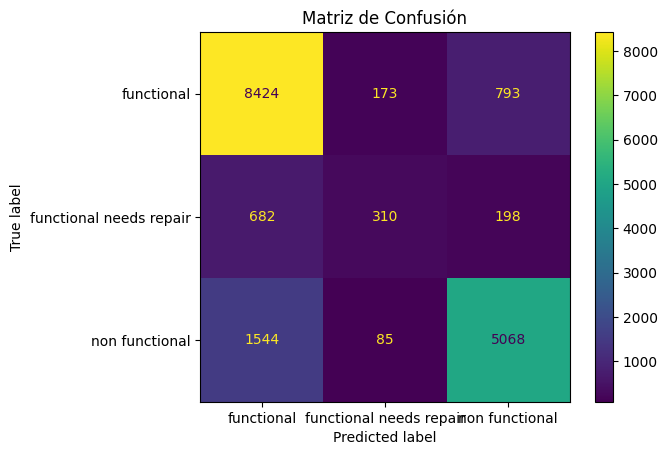

In [49]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le.classes_)
disp.plot(cmap='viridis', values_format='d')
plt.title("Matriz de Confusión")
plt.show()

In [52]:
# Predicciones en el conjunto de entrenamiento
y_pred_train = best_model.predict(X_train)

# Predicciones en el conjunto de prueba
y_pred_test = best_model.predict(X_test)

In [53]:
# Reporte para el conjunto de entrenamiento
print("Train Classification Report:")
print(classification_report(y_train, y_pred_train, target_names=le.classes_))

# Reporte para el conjunto de prueba
print("Test Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

Train Classification Report:
                         precision    recall  f1-score   support

             functional       0.88      0.97      0.92     21999
functional needs repair       0.90      0.62      0.73      2741
         non functional       0.94      0.86      0.90     15570

               accuracy                           0.90     40310
              macro avg       0.91      0.81      0.85     40310
           weighted avg       0.90      0.90      0.90     40310

Test Classification Report:
                         precision    recall  f1-score   support

             functional       0.79      0.90      0.84      9390
functional needs repair       0.55      0.26      0.35      1190
         non functional       0.84      0.76      0.79      6697

               accuracy                           0.80     17277
              macro avg       0.72      0.64      0.66     17277
           weighted avg       0.79      0.80      0.79     17277

